## FreqPulse-VAE: A Frequency-Conditioned Variational Autoencoder for Pulsatile Signal Generation

In [1]:
import os
import numpy as np
import pandas as pd
import yaml
from tqdm import trange, tqdm
from functools import reduce


import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, GRU, Dense, Masking, Reshape, Flatten, RepeatVector, TimeDistributed, Bidirectional, Activation, GaussianNoise, Lambda, LSTM
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from Models.MainModel import *
from Utilities.Utilities import *
from Utilities.EvaluationModules import *
from Models.Losses import *

import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="4"

def read_yaml(file_path):
    with open(file_path, 'r') as file:
        return yaml.safe_load(file)

#### Env setting

In [2]:
ConfigName = 'SKZFC_ART_50_800'


if 'ART' in ConfigName:
    LoadConfig = 'Config' + 'ART'
elif 'PLETH' in ConfigName:
    LoadConfig = 'Config' + 'PLETH'
elif 'II' in ConfigName:
    LoadConfig = 'Config' + 'II'
else:
    assert False, "Please verify if the data type is properly included in the name of the configuration. The configuration name should be structured as 'Config' + 'data type', such as ConfigART."

yaml_path = './Config/'+LoadConfig+'.yml'

SavePath = './Results/'
ConfigSet = read_yaml(yaml_path)

### Model related parameters
SigType = ConfigSet[ConfigName]['SigType']
LatDim = ConfigSet[ConfigName]['LatDim']
CompSize = ConfigSet[ConfigName]['CompSize']

MaskingRate = ConfigSet[ConfigName]['MaskingRate']
NoiseStd = ConfigSet[ConfigName]['NoiseStd']
MaskStd = ConfigSet[ConfigName]['MaskStd']
ReparaStd = ConfigSet[ConfigName]['ReparaStd']
FcLimit = ConfigSet[ConfigName]['FcLimit']
DecayH = ConfigSet[ConfigName]['DecayH']
DecayL = ConfigSet[ConfigName]['DecayL']


ModelName = ConfigName+'.hdf5'
### Model checkpoint
ModelSaveName = SavePath+ModelName


### Data

In [3]:
TrData = np.load('./Data/ProcessedData/Tr'+str(SigType)+'.npy')
ValData = np.load('./Data/ProcessedData/Val'+str(SigType)+'.npy')

SigDim = ValData.shape[1]
DataSize = ValData.shape[0]

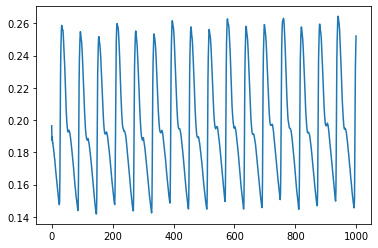

In [4]:
plt.plot(ValData[9])

0.1

### Post model

In [4]:
# Defining Modesl
EncModel = Encoder(SigDim=SigDim, LatDim= LatDim, Type = '', MaskingRate = MaskingRate, NoiseStd = NoiseStd, MaskStd = MaskStd, ReparaStd = 1, Reparam=True, FcLimit=FcLimit)
FeatExtModel = FeatExtractor(SigDim=SigDim, CompSize = CompSize, DecayH=DecayH, DecayL=DecayL)
FeatGenModel = FeatGenerator(SigDim=SigDim,FeatDim=FeatExtModel.output[1].shape[-1], LatDim= LatDim)
ReconModel = Reconstructor(SigDim=SigDim, FeatDim=FeatExtModel.output[1].shape[-1])

Models = [EncModel,FeatExtModel,FeatGenModel,ReconModel] 

# Adding losses
SigRepModel = TCLosses(Models, DataSize, ConfigSet[ConfigName])


### Load weights
SigRepModel.load_weights(ModelSaveName)

### Regularizer resetting
for i in SigRepModel.weights:
    if i.name.split('/')[0] in ['Beta_Z','Beta_Fc','Beta_TC', 'Beta_MI' ,'Beta_Orig', 'Beta_Feat']:
        i.assign(1.)
        
## Model Compile
SigRepModel.compile(optimizer='adam') 
SigRepModel.summary()

OrigRecLoss added
FeatRecLoss added
kl_Loss_SKZ selected
kl_Loss_Z added
kl_Loss_FC added
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inp_Enc (InputLayer)            [(None, 1000)]       0                                            
__________________________________________________________________________________________________
tf.signal.frame (TFOpLambda)    (None, 20, 50)       0           Inp_Enc[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 20, 50)       11550       tf.signal.frame[0][0]            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 20, 50)       11550       bidirectional[0][0]              
____

#### Computing Q(z|x)

In [5]:
def Comp_Q_zCx (PostAnalData):
    Z_Mu_Out = SigRepModel.get_layer('Z_Mu').output
    Zs_Out = SigRepModel.get_layer('Zs').output
    Z_Sigma_Out = SigRepModel.get_layer('Z_Log_Sigma').output
    Sampler = Model(EncModel.input, [Z_Mu_Out, Zs_Out, Z_Sigma_Out])
    return Sampler.predict(PostAnalData, batch_size=2000, verbose=1)

In [91]:
ZMu_C_Y, Zs_C_Y, Sigma_C_Y = Comp_Q_zCx (ValData)

30/30 [==============================] - 6s 139ms/step


In [6]:
def ProbFreq (Data, NMiniBat, N_Gen, MinFreq = 1, MaxFreq = 51):
    
    ### Conducting FFT 
    HalfLen = Data.shape[-1]//2
    FFTRes = np.abs(np.fft.fft(Data, axis=-1)[..., :HalfLen]) 
    Amplitude = FFTRes/HalfLen
    SelAmplitude = Amplitude[..., MinFreq:MaxFreq]
    NFreq = SelAmplitude.shape[-1]

    ### Selecting the amplitude of discrete Fourier transform (FFT) where the count of the amplitude is equal to or greater than the top maximum amplitude, TopNMaxAmpl.
    if len(Data.shape) >2 :
        #print('3D matrix processed') 
        MaxAmplitudeLabel = np.argmax(SelAmplitude, axis=-1) + 1
        Counts = np.zeros((NMiniBat,NFreq))
        for Row in range(Counts.shape[0]):
            FreqLabels, FreqCounts = np.unique(MaxAmplitudeLabel[Row], return_counts=True, axis=-1)
            for Col, FreqCount in zip(FreqLabels, FreqCounts):
                Counts[Row, Col] = FreqCount

        ### Probability of frequencies per each mini batch
        ProbMaxV = Counts / N_Gen

    else:
        #print('2D matrix processed')
        MaxAmplitudeLabel = np.argmax(SelAmplitude, axis=-1) + 1
        MaxV, Count = np.unique(MaxAmplitudeLabel, return_counts=True)
        MaxVLabel =  np.arange(MaxFreq - MinFreq) + 1
        Count_ = np.zeros_like(MaxVLabel)
        MaxVLabelCount = np.concatenate([MaxVLabel[:,None], Count_[:,None]], axis=-1)
        MaxVLabelCount[MaxV, 1] = Count

        ### Probability of frequencies 
        ProbMaxV = MaxVLabelCount[:, 1] / np.sum(MaxVLabelCount[:, 1])
    
    return np.maximum(ProbMaxV, 1e-7)
    
    
def Sampler (Data):
    #Z_Mu_Out = SigRepModel.get_layer('Z_Mu').output
    Zs_Out = SigRepModel.get_layer('Zs').output
    #Z_Sigma_Out = SigRepModel.get_layer('Z_Log_Sigma').output
    FCs_Out = SigRepModel.get_layer('FCs').output
    Sampler = Model(EncModel.input, [Zs_Out, FCs_Out])
    return Sampler.predict(Data, batch_size=2000, verbose=1)   

In [ ]:
AnalData = ValData

MaxFreq = 51
MinFreq = 1
NMiniBat = 100
SimSize = 1
MinFreqR=0.
MaxFreqR=0.05
N_Gen = 300
Ndata = len(ValData)
MASize = Ndata//NMiniBat

FC_Comm = np.tile(np.linspace(MinFreqR, MaxFreqR, N_Gen )[:, None], (1,2))
FC_Each = np.tile(np.linspace(MinFreqR, MaxFreqR, N_Gen )[:, None], (1,4))


# P_V
P_V = ProbFreq (AnalData, NMiniBat, N_Gen, MinFreq = 1, MaxFreq = 51)

### monte carlo approximation
I_V_z = 0
I_VFc_z = 0

for sim in range(SimSize):
    
    SplitData = np.array_split(AnalData, MASize)
    with trange(MASize, leave=False) as t:

        for mini in range(MASize):
            #print(sim, mini, MASize)
            
            Mask_Z = np.zeros((NMiniBat, LatDim))
            for i in range(NMiniBat):
                Mask_Z[i, np.random.choice(LatDim)] = 1

            # Sampling
            print('Sampling Samp_Zs and FCs_Z')
            Samp_Zs, FCs_Z = Sampler(SplitData[mini])
            Samp_Zs *= Mask_Z
            FCs_Z[:, :] = FcLimit * 0.5
            FC_Comm_Z = FCs_Z[:, :2]
            FC_Each_Z  = FCs_Z[:, 2:]

            # I(V;z)
            print('Predicting SigGen_Z')
            FeatGen_Z = FeatGenModel.predict([FC_Comm_Z,FC_Each_Z, Samp_Zs], batch_size=4000, verbose=1)
            SigGen_Z = ReconModel.predict([FeatGen_Z], batch_size=4000, verbose=1)
            Q_V_Z = ProbFreq (SigGen_Z, NMiniBat, N_Gen, MinFreq = 1, MaxFreq = 51)

            # I(V;z)
            I_V_z += np.sum(Q_V_Z * np.log(Q_V_Z / P_V))


            # Expanding the data dimension for signal generation based on the frequency component (FC) 
            Samp_Zs_Ext =  np.broadcast_to(Samp_Zs[:, None], (NMiniBat, N_Gen, LatDim)).reshape(-1, LatDim)
            FC_Comm_Ext =  np.broadcast_to(FC_Comm[None], (NMiniBat, N_Gen, FC_Comm.shape[-1])).reshape(-1, FC_Comm.shape[-1])
            FC_Each_Ext =  np.broadcast_to(FC_Each[None], ( NMiniBat, N_Gen, FC_Each.shape[-1])).reshape(-1, FC_Each.shape[-1])

            # Q_V_ZFc
            print('Predicting SigGen_ZFc')
            FeatGen_ZFc = FeatGenModel.predict([FC_Comm_Ext,FC_Each_Ext, Samp_Zs_Ext], batch_size=4000, verbose=1)
            SigGen_ZFc = ReconModel.predict([FeatGen_ZFc], batch_size=4000, verbose=1).reshape(NMiniBat, N_Gen, -1)
            SigGen_ZFc = SigGen_ZFc.reshape(NMiniBat*N_Gen, -1)
            Q_V_ZFc =ProbFreq (SigGen_ZFc, NMiniBat, N_Gen,  MinFreq = MinFreq, MaxFreq = MaxFreq)

            # I(V;Fc|z)
            I_VFc_z += np.sum(Q_V_ZFc * np.log(Q_V_ZFc / Q_V_Z))
            print('I_V_z : ', I_V_z, 'I_VFc_z : ', I_VFc_z )
            t.update(1)

I_V_z /= (MASize*SimSize)
I_VFc_z /= (MASize*SimSize)

I_V_z + I_VFc_z 

0.6406305666709932

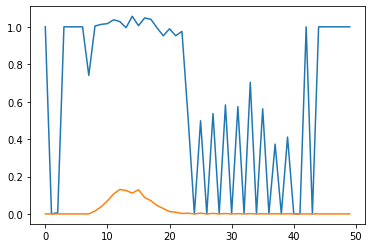

In [50]:
plt.plot(Q_V_Z / P_V)
plt.plot(Q_V_Z)

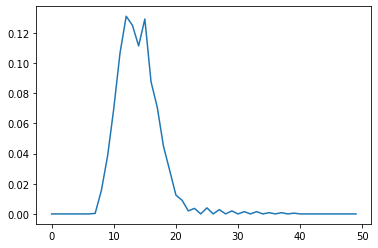

In [53]:
plt.plot(Q_V_Z)

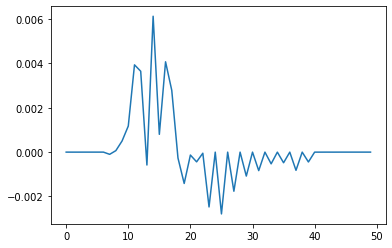

In [51]:
plt.plot(Q_V_Z * np.log(Q_V_Z / P_V))

In [65]:
    Data = SigGen_Z
    ### Conducting FFT 
    HalfLen = Data.shape[-1]//2
    FFTRes = np.abs(np.fft.fft(Data, axis=-1)[..., :HalfLen]) 
    Amplitude = FFTRes/HalfLen
    SelAmplitude = Amplitude[..., MinFreq:MaxFreq]
    NFreq = SelAmplitude.shape[-1]

    ### Selecting the amplitude of discrete Fourier transform (FFT) where the count of the amplitude is equal to or greater than the top maximum amplitude, TopNMaxAmpl.
    if len(Data.shape) >2 :
        #print('3D matrix processed') 
        MaxAmplitudeLabel = np.argmax(SelAmplitude, axis=-1) + 1
        Counts = np.zeros((NMiniBat,NFreq))
        for Row in range(Counts.shape[0]):
            FreqLabels, FreqCounts = np.unique(MaxAmplitudeLabel[Row], return_counts=True, axis=-1)
            for Col, FreqCount in zip(FreqLabels, FreqCounts):
                Counts[Row, Col] = FreqCount

        ### Probability of frequencies per each mini batch
        ProbMaxV = Counts / N_Gen

    else:
        #print('2D matrix processed')
        MaxAmplitudeLabel = np.argmax(SelAmplitude, axis=-1) + 1
        MaxV, Count = np.unique(MaxAmplitudeLabel, return_counts=True)
        MaxVLabel =  np.arange(MaxFreq - MinFreq) + 1
        Count_ = np.zeros_like(MaxVLabel)
        MaxVLabelCount = np.concatenate([MaxVLabel[:,None], Count_[:,None]], axis=-1)
        MaxVLabelCount[MaxV, 1] = Count

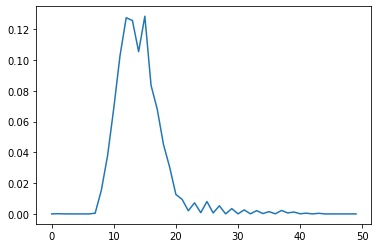

In [64]:
plt.plot(MaxVLabelCount[:, 1] / np.sum(MaxVLabelCount[:, 1]))

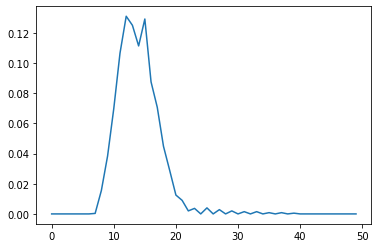

In [66]:
plt.plot(MaxVLabelCount[:, 1] / np.sum(MaxVLabelCount[:, 1]))

In [34]:
SplitData[mini].shape

(6000, 1000)

In [35]:
Samp_Zs.shape

(6000, 50)

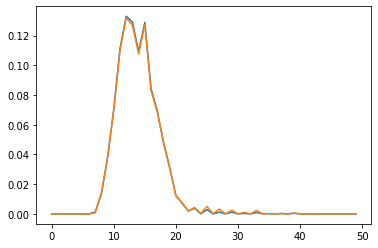

In [26]:
plt.plot(Q_V_ZFc)
plt.plot(Q_V_Z)

In [23]:
np.sum(Q_V_ZFc * np.log(Q_V_ZFc / Q_V_Z))

0.004122562833904076

In [15]:
I_V_z + I_VFc_z

0.013142888563096268

0.0026061203627554107

In [14]:
MASize*SimSize

10

In [486]:
Samp_Zs_Ext =  np.broadcast_to(Samp_Zs[:, None], (NMiniBat, N_Gen, LatDim)).reshape(-1, LatDim)
FC_Comm_Ext =  np.broadcast_to(FC_Comm[None], (NMiniBat, N_Gen, FC_Comm.shape[-1])).reshape(-1, FC_Comm.shape[-1])
FC_Each_Ext =  np.broadcast_to(FC_Each[None], ( NMiniBat, N_Gen, FC_Each.shape[-1])).reshape(-1, FC_Each.shape[-1])

# Q_V_ZFc
FeatGen_ZFc = FeatGenModel.predict([FC_Comm_Ext,FC_Each_Ext, Samp_Zs_Ext], batch_size=2000, verbose=1)
SigGen_ZFc = ReconModel.predict([FeatGen_ZFc], batch_size=2000, verbose=1).reshape(NMiniBat, N_Gen, -1)
SigGen_ZFc = SigGen_ZFc.reshape(NMiniBat*N_Gen, -1)
#Q_V_ZFc =ProbFreq (SigGen_ZFc, MinFreq = 1, MaxFreq = 51)



50/50 [==============================] - 8s 166ms/step


In [487]:
### Conducting FFT 
Data = SigGen_ZFc
NMiniBat, N_Gen

HalfLen = Data.shape[-1]//2
FFTRes = np.abs(np.fft.fft(Data, axis=-1)[..., :HalfLen]) 
Amplitude = FFTRes/HalfLen
SelAmplitude = Amplitude[..., MinFreq:MaxFreq]
NFreq = SelAmplitude.shape[-1]

### Selecting the amplitude of discrete Fourier transform (FFT) where the count of the amplitude is equal to or greater than the top maximum amplitude, TopNMaxAmpl.
if len(Data.shape) >2 :
    print('3D matrix processed') 
    MaxAmplitudeLabel = np.argmax(SelAmplitude, axis=-1) + 1
    Counts = np.zeros((NMiniBat,NFreq))
    for Row in range(Counts.shape[0]):
        FreqLabels, FreqCounts = np.unique(MaxAmplitudeLabel[Row], return_counts=True, axis=-1)
        for Col, FreqCount in zip(FreqLabels, FreqCounts):
            Counts[Row, Col] = FreqCount
            
    ### Probability of frequencies per each mini batch
    ProbMaxV = Counts / N_Gen
    
else:
    print('2D matrix processed')
    MaxAmplitudeLabel = np.argmax(SelAmplitude, axis=-1) + 1
    MaxV, Count = np.unique(MaxAmplitudeLabel, return_counts=True)
    MaxVLabel =  np.arange(MaxFreq - MinFreq) + 1
    Count_ = np.zeros_like(MaxVLabel)
    MaxVLabelCount = np.concatenate([MaxVLabel[:,None], Count_[:,None]], axis=-1)
    MaxVLabelCount[MaxV, 1] = Count
    
    ### Probability of frequencies 
    ProbMaxV = MaxVLabelCount[:, 1] / np.sum(MaxVLabelCount[:, 1])

2D matrix processed


array([0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
       0.     , 0.01388, 0.03847, 0.06917, 0.12316, 0.12105, 0.11929,
       0.12771, 0.11663, 0.08757, 0.07258, 0.04788, 0.02762, 0.01406,
       0.01081, 0.     , 0.0014 , 0.     , 0.00166, 0.     , 0.00069,
       0.     , 0.0003 , 0.     , 0.00347, 0.     , 0.00111, 0.     ,
       0.00102, 0.     , 0.     , 0.     , 0.00047, 0.     , 0.     ,
       0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
       0.     ])

In [ ]:
MaxVLabelCount

In [325]:
    ### Selecting the amplitude of discrete Fourier transform (FFT) where the count of the amplitude is equal to or greater than the top maximum amplitude, TopNMaxAmpl.
    MaxAmplitudeLabel = np.argmax(SelAmplitude, axis=-1) + 1
    MaxV, Count = np.unique(MaxAmplitudeLabel, return_counts=True)
    MaxVLabel =  np.arange(MaxFreq - MinFreq) + 1
    Count_ = np.zeros_like(MaxVLabel)
    MaxVLabelCount = np.concatenate([MaxVLabel[:,None], Count_[:,None]], axis=-1)
    #MaxVLabelCount[MaxV, 1] = Count

    ### Probability of frequencies 
    ProbMaxV = MaxVLabelCount[:, 1] / np.sum(MaxVLabelCount[:, 1])

<ipython-input-325-b8a810c01679>:10: RuntimeWarning: invalid value encountered in true_divide
  ProbMaxV = MaxVLabelCount[:, 1] / np.sum(MaxVLabelCount[:, 1])


In [9]:
## sample from p(z|x)
np.random.seed(1)
Samp_zCx = np.random.permutation(Samp_zCx)[:Nsamples]
Nsamples = len(Samp_zCx)
Samp_zCx = tf.reshape(Samp_zCx, [LatDim, Nsamples])
Mean = tf.broadcast_to(Mu_zCx[:,:,None], [Ndata, LatDim, Nsamples])
LogVar = tf.broadcast_to(Sig_zCx[:,:,None], [Ndata, LatDim, Nsamples])
LogN = np.log(Ndata)

In [24]:
k = 0
MiniBatSize = 8
idcs = slice(k, k + MiniBatSize)
Log_Q_zCx  = LogNormalDensity(Samp_zCx[None][..., idcs], Mean[..., idcs], LogVar[..., idcs])

(1, 50, 8) (27667, 50, 8) (27667, 50, 8)


In [ ]:
Mean.shape

In [5]:
def LogNormalDensity(LatSamp, LatMean, LogSquaScale):
    print(LatSamp.shape, LatMean.shape, LogSquaScale.shape)
    Norm = tf.math.log(2. * tf.constant(np.pi))
    InvSigma = tf.math.exp(-LogSquaScale)
    MeanSampDiff = (LatSamp - LatMean)
    return -0.5 * (MeanSampDiff * MeanSampDiff * InvSigma + LogSquaScale + Norm)

#### Labeling and data selection

In [6]:
NMaxSel = 2 #The top N number of frequencies indicating the maximum amplitude values for labeling
MaxFreq = 51
MinFreq = 1
TopNMaxAmpl = 10 #The top N number of frequencies indicating the maximum amplitude values after FFT (Fast Fourier Transform).
LimitLatSize = 20000 #The maximum number of samples to be taken from TopNMaxAmpl.
Nsamples = 2000 #The number of samples for computing E_q(z)[logq(z)]
MiniBatSize = 10 #The batch size for Monte Carlo approximation for the marginal entropies H(z_j)  



np.random.seed(1)
PermValData = np.random.permutation(ValData)

### Conducting FFT 
HalfLen = PermValData.shape[1]//2
FFTRes = np.abs(np.fft.fft(PermValData, axis=-1)[:, :HalfLen]) 
Amplitude = FFTRes/HalfLen
SelAmplitude = Amplitude[:, MinFreq:MaxFreq]



### Selecting the amplitude of discrete Fourier transform (FFT) where the count of the amplitude is equal to or greater than the top maximum amplitude, TopNMaxAmpl.
MaxAmplitudeLabel = np.argmax(SelAmplitude, axis=-1) + 1

#### stringify top N frequencies
MaxAmplitudeLabel = np.argsort(-SelAmplitude, axis=-1)[:, :NMaxSel] + 1
Ndigit = len(str(MaxFreq))

#### Convert to string array and pad zeros
StrMaxAmplitudeLabel = np.array([[str(i).zfill(Ndigit) for i in inner] for inner in MaxAmplitudeLabel])

#### Concatenate strings in each row
StrMaxAmplitudeLabel = np.array(['-'.join(row) for row in StrMaxAmplitudeLabel])

#### Setting condition masks
FreqLabel, FreqCount = np.unique(StrMaxAmplitudeLabel, return_counts=True)
CutTopMaxAmp = np.sort(FreqCount)[-TopNMaxAmpl]
CutFreqLabel = FreqLabel[FreqCount >= CutTopMaxAmp]
CutSizes = FreqCount[FreqCount >= CutTopMaxAmp]


### Selecting analysis observations and labels; Selecting a manageable amount of data for analysis, not an overwhelming amount.
PostAnalData = []
PostAnalFreqLabel = []
for Freq,LatSize in zip(CutFreqLabel, CutSizes):
    print(Freq, LatSize)
    SelLatData = PermValData[StrMaxAmplitudeLabel == Freq]
    SelFreqLabel = StrMaxAmplitudeLabel[StrMaxAmplitudeLabel == Freq]
    PostAnalData.append(SelLatData[:LimitLatSize])
    PostAnalFreqLabel.append(SelFreqLabel[:LimitLatSize])

PostAnalData = np.concatenate(PostAnalData)        
PostAnalFreqLabel = np.concatenate(PostAnalFreqLabel)       
Ndata = len(PostAnalData)
LatSizes = (np.unique(PostAnalFreqLabel, return_counts=True)[1])

09-18 1283
10-20 2064
11-22 3114
12-24 3867
13-26 4017
14-28 3187
15-30 4247
16-32 2561
17-34 1959
18-36 1368


#### Computing Q(z|x)

In [7]:
def Comp_Q_zCx ():
    Z_Mu_Out = SigRepModel.get_layer('Z_Mu').output
    Zs_Out = SigRepModel.get_layer('Zs').output
    Z_Sigma_Out = Zs_Out = SigRepModel.get_layer('Z_Log_Sigma').output
    Sampler = Model(EncModel.input, [Z_Mu_Out, Zs_Out, Z_Sigma_Out])
    return Sampler.predict(PostAnalData, batch_size=2000, verbose=1)


64/64 [==============================] - 10s 140ms/step


#### Computing marginal entropy H(z_j)

In [9]:
def Comp_LatEntro (Samp_zCx, Mu_zCx, Sig_zCx, Nsamples=100, MiniBatSize=10 ):
    Ndata = Samp_zCx.shape[0]
    LatDim = Samp_zCx.shape[1]
    
    ## sample from p(z|x)
    np.random.seed(1)
    Samp_zCx = np.random.permutation(Samp_zCx)[:Nsamples]
    Nsamples = len(Samp_zCx)
    Samp_zCx = tf.reshape(Samp_zCx, [LatDim, Nsamples])
    Mean = tf.broadcast_to(Mu_zCx[:,:,None], [Ndata, LatDim, Nsamples])
    LogVar = tf.broadcast_to(Sig_zCx[:,:,None], [Ndata, LatDim, Nsamples])
    LogN = np.log(Ndata)

    ### Monte Carlo approximation for the marginal entropies H(z_j)  
    H_z = np.zeros(LatDim)
    with trange(Nsamples, leave=False) as t:
        for k in range(0, Nsamples, MiniBatSize):
            #print('Simulation iteration', k//MiniBatSize)
            idcs = slice(k, k + MiniBatSize)
            Log_Q_zCx  = LogNormalDensity(Samp_zCx[None][..., idcs], Mean[..., idcs], LogVar[..., idcs])
            Log_Q_z = -LogN + tf.math.reduce_logsumexp(Log_Q_zCx, axis=0, keepdims=False)
            H_z += tf.reduce_sum(-Log_Q_z, axis=1)

            t.update(MiniBatSize)

    # the marginal entropies H(z_j)  
    H_z /= Nsamples

    return H_z

In [10]:
### Computing Q(z|x) and related parameters
Mu_zCx, Samp_zCx, Sig_zCx = Comp_Q_zCx()

### marginal entropy H(z_j)
H_z = Comp_LatEntro(Samp_zCx, Mu_zCx, Sig_zCx, Nsamples, MiniBatSize)

64/64 [==============================] - 11s 150ms/step


  0%|                                                                                         | 0/2000 [00:00<?, ?it/s]

(1, 50, 10) (126516, 50, 10) (126516, 50, 10)


  0%|▍                                                                               | 10/2000 [00:00<03:06, 10.68it/s]

(1, 50, 10) (126516, 50, 10) (126516, 50, 10)


  1%|▊                                                                               | 20/2000 [00:01<02:57, 11.18it/s]

(1, 50, 10) (126516, 50, 10) (126516, 50, 10)


  2%|█▏                                                                              | 30/2000 [00:02<03:02, 10.78it/s]

(1, 50, 10) (126516, 50, 10) (126516, 50, 10)


  2%|█▌                                                                              | 40/2000 [00:03<03:06, 10.52it/s]

(1, 50, 10) (126516, 50, 10) (126516, 50, 10)


  2%|██                                                                              | 50/2000 [00:04<03:08, 10.33it/s]

(1, 50, 10) (126516, 50, 10) (126516, 50, 10)


  3%|██▍                                                                             | 60/2000 [00:05<03:09, 10.26it/s]

(1, 50, 10) (126516, 50, 10) (126516, 50, 10)


  4%|██▊                                                                             | 70/2000 [00:06<03:16,  9.80it/s]

(1, 50, 10) (126516, 50, 10) (126516, 50, 10)


  4%|███▏                                                                            | 80/2000 [00:07<03:20,  9.57it/s]

(1, 50, 10) (126516, 50, 10) (126516, 50, 10)


  4%|███▌                                                                            | 90/2000 [00:09<03:20,  9.55it/s]

(1, 50, 10) (126516, 50, 10) (126516, 50, 10)


  5%|███▉                                                                           | 100/2000 [00:10<03:24,  9.31it/s]

(1, 50, 10) (126516, 50, 10) (126516, 50, 10)


  6%|████▎                                                                          | 110/2000 [00:11<03:22,  9.32it/s]

(1, 50, 10) (126516, 50, 10) (126516, 50, 10)


  6%|████▋                                                                          | 120/2000 [00:12<03:19,  9.40it/s]

(1, 50, 10) (126516, 50, 10) (126516, 50, 10)


KeyboardInterrupt: 

### Stratification by frequency-based labels

In [264]:
SplitInd = np.cumsum(LatSizes)[:-1]
Sep_Samp_zCx = np.split(Samp_zCx, SplitInd)
Sep_Mu_zCx = np.split(Mu_zCx, SplitInd)
Sep_Sig_zCx = np.split(Sig_zCx, SplitInd)

10

#### Computing conditional entropy H(z|v)
#### # I[z_j;v_k] = E[log \sum_x q(z_j|x)p(x|v_k)] + H[z_j] = - H[z_j|v_k] + H[z_j]

In [267]:
Set_H_zCv = []
MI = []
for Lat in range(len(LatSizes)):
    H_zCv = Comp_LatEntro(Sep_Samp_zCx[Lat].astype('float32'), Sep_Mu_zCx[Lat].astype('float32'), Sep_Sig_zCx[Lat].astype('float32'), Nsamples, MiniBatSize) / len(LatSizes)
    Set_H_zCv.append(H_zCv)
    MI.append(np.maximum(H_z - H_zCv, 0.)[None])
MI = np.concatenate(MI)
SortedMI = np.sort(MI, axis=1)[:, ::-1]
NormMI = SortedMI / np.log(LatSizes)[:,None]

MIG = np.mean(NormMI[:, 0] - NormMI[:, 1])

In [268]:
MIG

0.002229388269746199

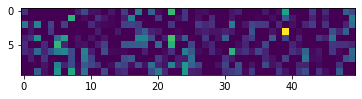

In [138]:
plt.imshow(MI)

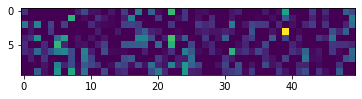

In [183]:
plt.imshow(MI)

In [114]:
H_z - H_zCv[3] 

<tf.Tensor: shape=(50,), dtype=float32, numpy=
array([-0.00788856, -0.00409245,  0.02957684, -0.0083167 ,  0.01558775,
        0.02071154, -0.00662786,  0.03602004, -0.02525645, -0.0113771 ,
        0.00618869,  0.00529206, -0.00081593, -0.000489  ,  0.00663126,
       -0.00219721,  0.0152775 , -0.02947688,  0.00180036, -0.03696048,
       -0.01590389,  0.00058371, -0.0320062 ,  0.00275552,  0.03099382,
       -0.00367385,  0.0098294 , -0.00311965,  0.00716817, -0.00373322,
       -0.04188472,  0.0210318 , -0.00782841, -0.02238989,  0.00516868,
        0.00351262, -0.00262761, -0.00236297,  0.00622904, -0.00613779,
        0.00770271, -0.02518511, -0.01344705,  0.00465083, -0.00332797,
        0.00943303, -0.00418746, -0.07438254, -0.00769979,  0.01362926],
      dtype=float32)>

In [233]:
H_zCv.shape

(3, 50)

In [232]:
def gaussian_entropy(log_var):
    """Compute the differential entropy for a multivariate Gaussian distribution."""
    return 0.5 * (1.0 + np.log(2 * np.pi * np.exp(log_var)))
from scipy.stats import norm

latent_dim = 50
lat_sizes = [2, 3, 4]
lat_names = ['var1', 'var2', 'var3']

# Create some dummy data for samples_zCx and params_zCx
samples_zCx = np.random.randn(*lat_sizes, latent_dim)
params_zCx = (np.random.randn(*lat_sizes, latent_dim), np.random.randn(*lat_sizes, latent_dim))

len_dataset = reduce((lambda x, y: x * y), lat_sizes)
H_zCv = np.zeros((len(lat_sizes), latent_dim))

for i_fac_var, (lat_size, lat_name) in enumerate(zip(lat_sizes, lat_names)):
    idcs = [slice(None)] * len(lat_sizes)
    for i in range(lat_size):
        #print("Estimating conditional entropies for the {}th value of {}.".format(i, lat_name))
        idcs[i_fac_var] = i
        print(idcs)
        # samples from q(z,x|v)
        samples_zxCv = samples_zCx[idcs].reshape(len_dataset // lat_size, latent_dim)
        params_zxCv = tuple(p[idcs].reshape(len_dataset // lat_size, latent_dim) for p in params_zCx)
        print(samples_zxCv.shape)
        print(samples_zxCv.shape[0] * samples_zxCv.shape[1])
        #print(params_zxCv[0].shape)
        
        print(i_fac_var)

[0, slice(None, None, None), slice(None, None, None)]
(12, 50)
600
0
[1, slice(None, None, None), slice(None, None, None)]
(12, 50)
600
0
[slice(None, None, None), 0, slice(None, None, None)]
(8, 50)
400
1
[slice(None, None, None), 1, slice(None, None, None)]
(8, 50)
400
1
[slice(None, None, None), 2, slice(None, None, None)]
(8, 50)
400
1
[slice(None, None, None), slice(None, None, None), 0]
(6, 50)
300
2
[slice(None, None, None), slice(None, None, None), 1]
(6, 50)
300
2
[slice(None, None, None), slice(None, None, None), 2]
(6, 50)
300
2
[slice(None, None, None), slice(None, None, None), 3]
(6, 50)
300
2


<ipython-input-232-7cdbab1570ad>:24: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  samples_zxCv = samples_zCx[idcs].reshape(len_dataset // lat_size, latent_dim)
<ipython-input-232-7cdbab1570ad>:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  params_zxCv = tuple(p[idcs].reshape(len_dataset // lat_size, latent_dim) for p in params_zCx)


In [88]:
tmp1 = np.random.rand(2,5,10)

In [197]:
tmp1[slice(None), 3].shape

(2, 10)

In [33]:
from functools import reduce
lat_sizes = [10, 20 ]
len_dataset = reduce((lambda x, y: x * y), lat_sizes)
#H_zCv = torch.zeros(len(lat_sizes), LatDim, device=self.device)
len_dataset

200

In [66]:
for i_fac_var, lat_size in enumerate(lat_sizes):
    idcs = [slice(None)] * len(lat_sizes)
    
    for i in range(lat_size):
        idcs[i_fac_var] = i
        print(i)
        Samp_zCx = tf.reshape(Samp_zCx[idcs], [len_dataset // lat_size, LatDim])

    

0


InvalidArgumentError: Input to reshape is a tensor with 1 values, but the requested shape has 1000 [Op:Reshape]

In [68]:
amples_zCx = Samp_zCx.view(*lat_sizes, latent_dim)

AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'view'

In [140]:
tmp = np.load('./dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz')

In [72]:
tmp.files

['metadata', 'imgs', 'latents_classes', 'latents_values']

In [148]:
np.unique(tmp['latents_classes'][:, 3], return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39], dtype=int64),
 array([18432, 18432, 18432, 18432, 18432, 18432, 18432, 18432, 18432,
        18432, 18432, 18432, 18432, 18432, 18432, 18432, 18432, 18432,
        18432, 18432, 18432, 18432, 18432, 18432, 18432, 18432, 18432,
        18432, 18432, 18432, 18432, 18432, 18432, 18432, 18432, 18432,
        18432, 18432, 18432, 18432], dtype=int64))

In [84]:
tmp2 = np.random.rand(3, 6, 40, 32, 32)

In [87]:
tmp2[:, 0].shape

(3, 40, 32, 32)

array([ 3,  6, 40, 32, 32])

#### Computing Q(zCx)


In [25]:
Nsamples = 1000
# Data permutation; sample from p(x)
np.random.seed(1)
PermValData = np.random.permutation(ValData)[:Nsamples]

# sample from p(z|x)
Z_Mu_Out = SigRepModel.get_layer('Z_Mu').output
Zs_Out = SigRepModel.get_layer('Zs').output
Z_Sigma_Out = Zs_Out = SigRepModel.get_layer('Z_Log_Sigma').output
Sampler = Model(EncModel.input, [Z_Mu_Out, Zs_Out, Z_Sigma_Out])
Mu_zCx, Samp_zCx_z, Samp_zCx_sig = Sampler.predict(PermValData, batch_size=2000, verbose=1)
Samp_zCx_z = tf.reshape(Samp_zCx_z, (LatDim, Nsamples))

1/1 [==============================] - 1s 972ms/step


### Reconstruction; MSE

In [38]:
RecPred = SigRepModel.predict(ValData,  batch_size=3500, verbose=1)[-1]

23/23 [==============================] - 14s 203ms/step


In [13]:
SigRepModel.evaluate(ValData,  batch_size=3000, verbose=1)

20/20 [==============================] - 40s 2s/step - loss: 2.1565 - OrigRecLoss: 7.0781e-04 - FeatRecLoss: 3.8414e-04 - kl_Loss_Z: 2.1514 - kl_Loss_FC: 5.3221e-04


[2.153000831604004,
 0.0007078081252984703,
 0.00038414227310568094,
 2.151376724243164,
 0.0005322062643244863]

In [ ]:
EvalMSE = tf.keras.losses.MeanSquaredError()
EvalMSE(ValData, RecPred)

### From extractor to reconstruction validation 
#### It ultimately evaluates the performance of the reconstructor

(100, 1000)


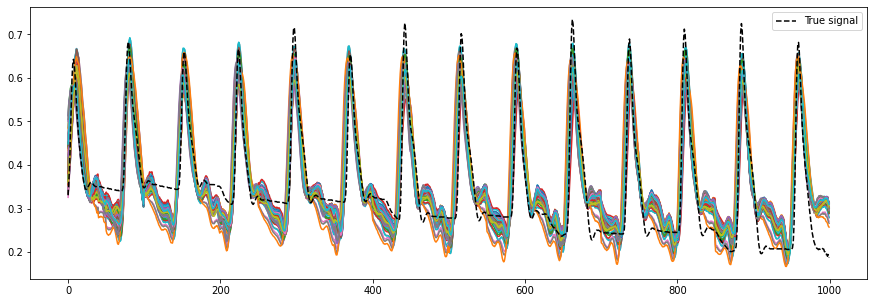

In [140]:
idx = 0

N_Gen = 100
'''
FC_Comm = np.tile(np.linspace(0.,0.05, N_Gen )[:, None], (1,2))
FC_Each = np.tile(np.linspace(0.,0.05, N_Gen )[:, None], (1,4))

'''
FC_Comm = np.tile(np.random.uniform(0, 0.05, N_Gen)[:, None], (1,2))
FC_Comm = np.sort(FC_Comm)
FC_Each = np.tile(np.random.uniform(0, 0.05, N_Gen)[:, None], (1,4))
FC_Each = np.sort(FC_Each) 


RecPred, HH,HL,LH, LL = VisReconExtract (ValData, idx, FeatExtModel, ReconModel, FC_Comm, FC_Each, N_Gen=N_Gen)

#### From extractor to reconstruction LL

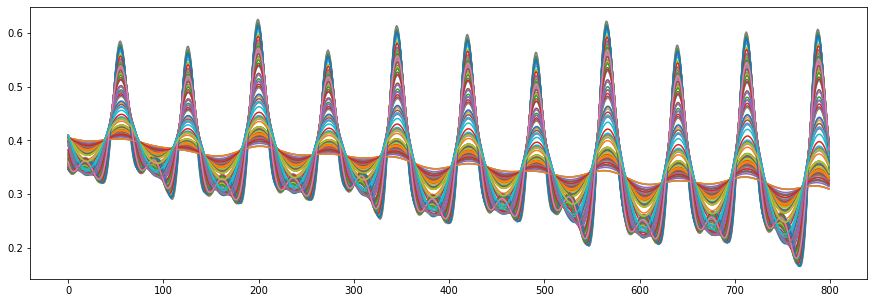

In [111]:
plt.figure(figsize=(15, 5))
for i in range(N_Gen):
    plt.plot(LL.numpy()[i])

#### From extractor to reconstruction HH

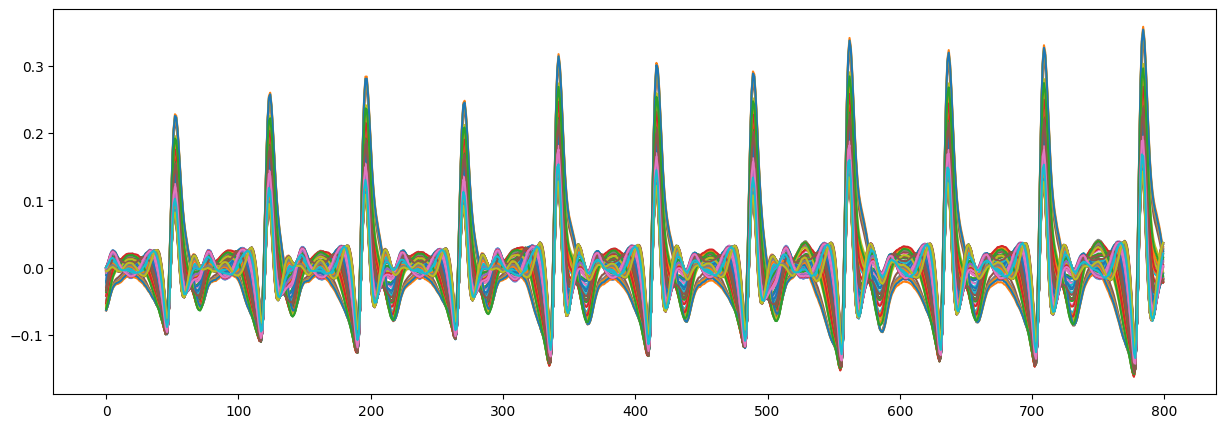

In [15]:
plt.figure(figsize=(15, 5))
for i in range(N_Gen):
    plt.plot(HH.numpy()[i])

In [22]:
DataSize = TrData.shape[0]


3.3333333333333333e-06

### The ratio of weighted power concentration to uncertainty (RWPCU)

In [107]:
RWPCU_Res = RWPCU(FeatGenModel,  ReconModel, LatDim=LatDim, N_Gen=300, N_Interval=20,
                  MinZval = -10., MaxZval = 10., N_FreqSel =3,  
                 MinFreq=1, MaxFreq=51)

['Lat_ID', 'zVal', 'Numerator', 'Denominator', 'VCSAE']
[0, -10.0, 0.29086, 0.3166, 0.91871]
[0, -8.95, 0.3036, 0.29688, 1.02264]
[0, -7.89, 0.23675, 0.27286, 0.86768]
[0, -6.84, 0.19681, 0.30154, 0.65269]
[0, -5.79, 0.24689, 0.35045, 0.70448]
[0, -4.74, 0.39896, 0.32375, 1.23233]
[0, -3.68, 0.60877, 0.34336, 1.77299]
[0, -2.63, 0.68837, 0.58132, 1.18413]
[0, -1.58, 0.42235, 0.44287, 0.95366]
[0, -0.53, 0.21029, 0.60277, 0.34888]
[0, 0.53, 0.19874, 0.18191, 1.09249]
[0, 1.58, 0.33477, 0.36537, 0.91624]
[0, 2.63, 0.32849, 0.26073, 1.25985]
[0, 3.68, 0.30456, 0.26394, 1.15391]
[0, 4.74, 0.27843, 0.30402, 0.91584]
[0, 5.79, 0.58087, 0.53878, 1.07812]
[0, 6.84, 0.69705, 0.55506, 1.25582]
[0, 7.89, 0.36901, 0.61635, 0.5987]
[0, 8.95, 0.26989, 0.55017, 0.49056]
[0, 10.0, 0.31507, 0.53014, 0.5943]
[1, -10.0, 0.33225, 0.38773, 0.85691]
[1, -8.95, 0.39507, 0.34163, 1.15643]
[1, -7.89, 0.7039, 0.31517, 2.23338]
[1, -6.84, 0.69505, 0.32117, 2.16411]
[1, -5.79, 0.79332, 0.39837, 1.99144]
[1, -4.74

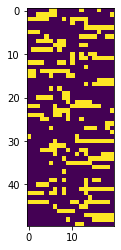

In [108]:
plt.imshow(np.array(RWPCU_Res)[:, -1].reshape(-1, 20) > 1.2)

### Qualitative evaluation of the amplitude relationship between the input frequency for signal generation (y-axis) and the frequency of the generated signal (x-axis).

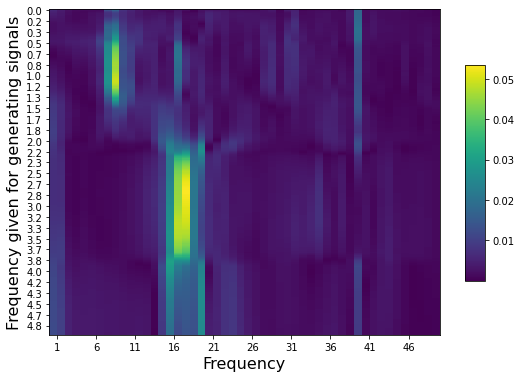

In [137]:
ZFix = {10:-10.0}
#ZFix = {2:1.32, 9:3.32}
#zVal[:,0] = -3
#Val[:,1] = 2.33
#zVal[:,2] = 0.4
#zVal[:,3] = -1.67
#zVal[:,4] = 0.33
#zVal[:,5] = 3
#zVal[:,6] = -1.67
#zVal[:,7] = 3
#zVal[:,8] = 3
#zVal[:,9] = -1

HeatMapFrequency(FeatGenModel,  ReconModel, LatDim, ZFix, N_Gen=300)

### Visualizing the reconstruction conditioned on a specific z-value when frequencies are given at regular intervals
#### Objective: This qualitatively evaluates the impact of changes in input frequencies on signal generation when a specific z-value is given.

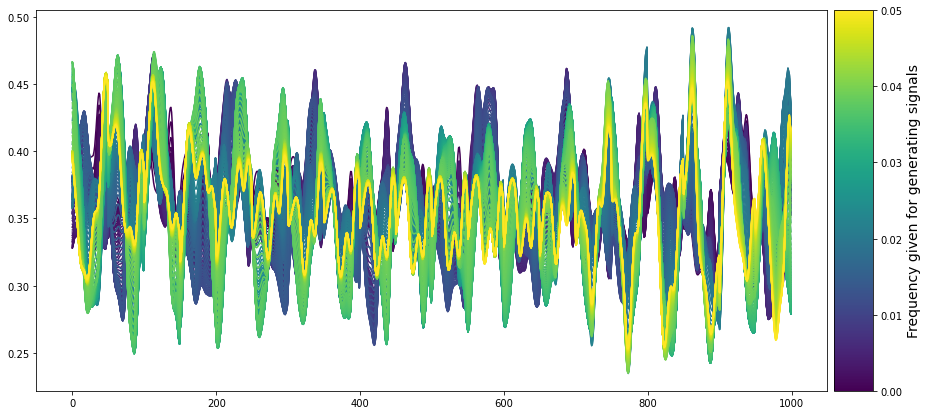

In [138]:
RecPred, HH,HL,LH, LL = VisReconGivenZ (FeatGenModel,  ReconModel, LatDim, ZFix, Mode='Origin', N_Gen=300, MinFreqR=0, MaxFreqR=0.05)

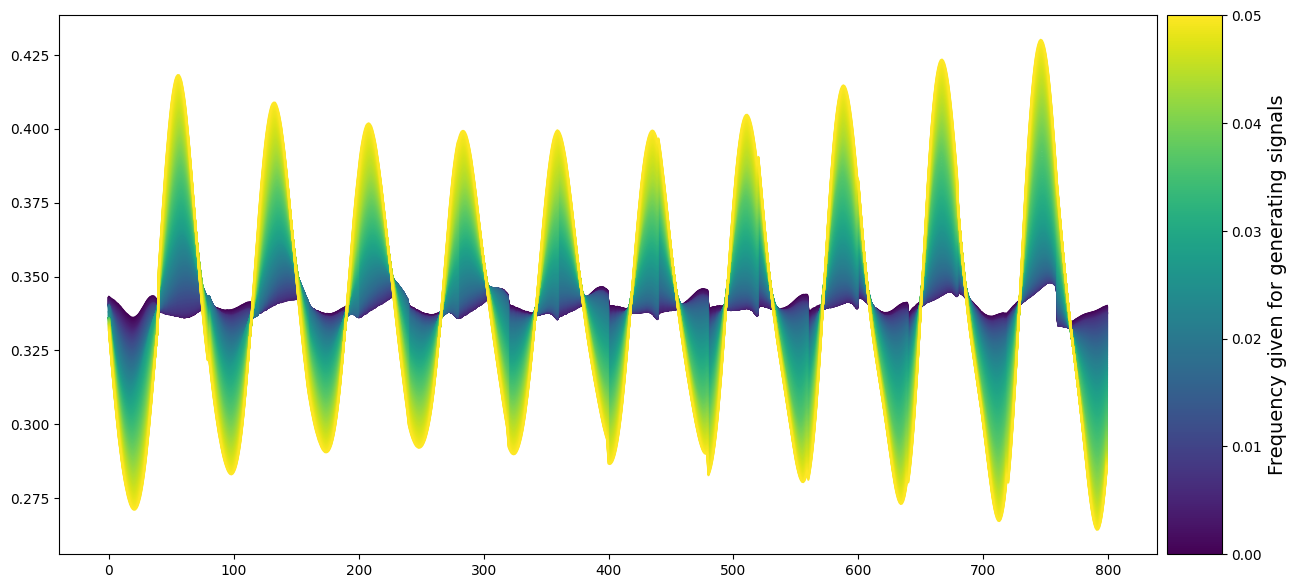

In [11]:
RecPred, HH,HL,LH, LL = VisReconGivenZ (FeatGenModel,  ReconModel, LatDim, ZFix, Mode='LL', N_Gen=300, MinFreqR=0, MaxFreqR=0.05)

### Visualizing the reconstruction conditioned on a specific frequency value when z-values are given at regular intervals
#### Objective: This qualitatively evaluates the impact of changes in input z-values on signal generation when a specific frequency is given.

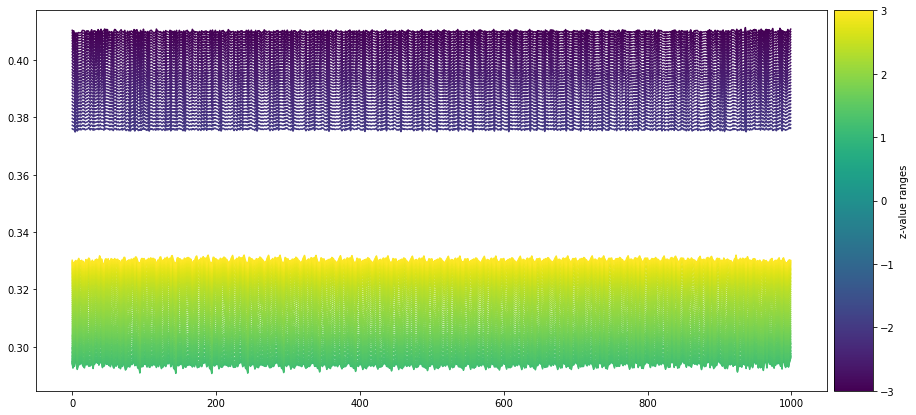

In [33]:
FcCommFix = {0:0.05, 1:0.05}
FcEachFix = {0:0.05, 1:0.05, 2:0.05, 3:0.05}
RecPred, HH,HL,LH, LL = VisReconGivenFreq (FeatGenModel,  ReconModel, LatDim, FcCommFix, FcEachFix,  Mode='Origin', N_Gen=200, MinZval = -3., MaxZval = 3., CutLower=-2., CutUpper = 1.)

### From generator to reconstruction validation

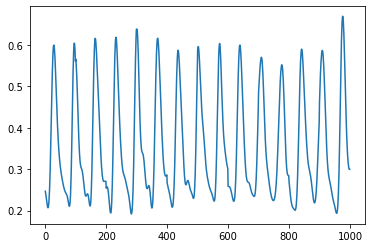

In [25]:
idx = 175
plt.plot(RecPred[idx])

### Visualizing amplitude by frequency given a specific ID

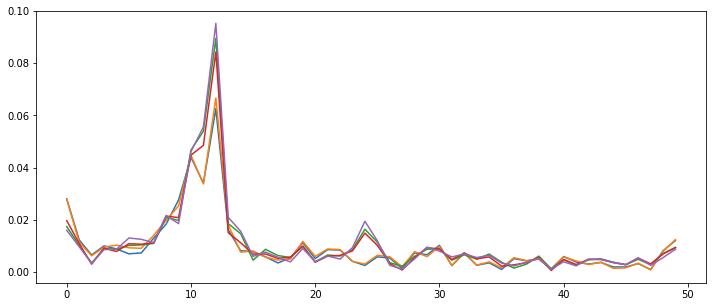

In [26]:
# GenSig_zVar
N_Gen= 300
SigGen5, Amplitude5 = GenSig_zVar(FeatGenModel, ReconModel, 0.05, N_Gen=N_Gen)
SigGen4, Amplitude4 = GenSig_zVar(FeatGenModel, ReconModel,  0.04, N_Gen=N_Gen)
SigGen3, Amplitude3 = GenSig_zVar(FeatGenModel, ReconModel,  0.03, N_Gen=N_Gen)
SigGen2, Amplitude2 = GenSig_zVar(FeatGenModel, ReconModel,  0.02, N_Gen=N_Gen)
SigGen1, Amplitude1 = GenSig_zVar(FeatGenModel, ReconModel,  0.01, N_Gen=N_Gen)

plt.figure(figsize=(12, 5))
idx = 20
plt.plot(Amplitude5[idx, 1:51])
plt.plot(Amplitude4[idx, 1:51])
plt.plot(Amplitude3[idx, 1:51])
plt.plot(Amplitude2[idx, 1:51])
plt.plot(Amplitude1[idx, 1:51])

In [62]:
JointEntropy 

<KerasTensor: shape=(None,) dtype=float32 (created by layer 'tf.math.reduce_logsumexp_13')>

In [60]:
MarginalEntropies

<KerasTensor: shape=(None,) dtype=float32 (created by layer 'tf.math.reduce_sum_104')>

In [ ]:
from sklearn.cluster import KMeans

MinFreq = 1
MaxFreq = 51
HalfLen = ValData.shape[1]//2
FFTRes = np.abs(np.fft.fft(ValData, axis=-1)[:, :HalfLen]) 
Amplitude = FFTRes/HalfLen
AmplitudeSet = Amplitude[:, MinFreq:MaxFreq]
MaxFreq = np.argmax(AmplitudeSet, axis=-1)

# perform KMeans clustering
km = KMeans(
    n_clusters=10,  # number of clusters
    init='random',  # method for initialization
    n_init=10,  # number of time the k-means algorithm will be run with different centroid seeds
    max_iter=300,  # maximum number of iterations for a single run
    tol=1e-04,  # relative tolerance with regards to inertia to declare convergence
    random_state=0  # seed used by the random number generator
)

y_km = km.fit_predict(AmplitudeSet)
np.unique(y_km, return_counts=True)